# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

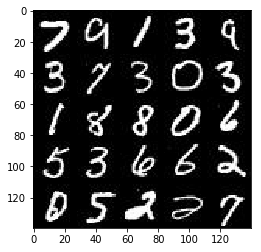

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

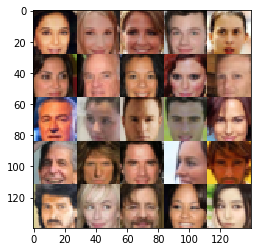

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_image_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_image_input')
    fake_z_input = tf.placeholder(tf.float32, (None, z_dim), name='fake_z_input')
    learn_rate = tf.placeholder(tf.float32, name='learning_rate')

    return (real_image_input, fake_z_input, learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


## Set Alpha

In [6]:
alpha = 0.2

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is MNIST Size
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #print(relu1.shape)

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(relu2.shape)

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print(relu3.shape)

        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        print('Disc: {}'.format(out.shape))
   

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Disc: (?, 1)
Disc: (?, 1)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        # fc layer
        x1 = tf.layers.dense(z, 7 *7 * 256)
        # 1st Layer
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.shape)
        
        # Add middle layer
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 3rd Layer
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.shape)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')

        #print(logits.shape)
        out = tf.tanh(logits)
        print('Gen: {}'.format(out.shape))
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)


Gen: (?, 28, 28, 5)
Gen: (?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels = (tf.ones_like(d_logits_real)* 0.8)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Gen: (?, 28, 28, 4)
Disc: (?, 1)
Disc: (?, 1)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # W and B
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_image_input, fake_z_input, learn_rate = model_inputs(data_shape[1],data_shape[2], data_shape[3] , z_dim)
    d_loss, g_loss = model_loss(real_image_input, fake_z_input, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples, losses = [], []
    print_every=10
    show_every=100
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # important step
                batch_images *= 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)) 

                # Run optimizers
                feed_train_dict = {real_image_input: batch_images, fake_z_input: batch_z, learn_rate: learning_rate}
                _ = sess.run(d_train_opt, feed_train_dict)
                _ = sess.run(g_train_opt, feed_train_dict)

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({fake_z_input: batch_z, real_image_input: batch_images})
                    train_loss_g = g_loss.eval({fake_z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),"Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    n_image=16
                    show_generator_output(sess, n_image, fake_z_input, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Gen: (?, 28, 28, 1)
Disc: (?, 1)
Disc: (?, 1)
Epoch 1/2... Discriminator Loss: 1.5456... Generator Loss: 0.6801
Epoch 1/2... Discriminator Loss: 1.7592... Generator Loss: 2.4844
Epoch 1/2... Discriminator Loss: 1.2058... Generator Loss: 1.4861
Epoch 1/2... Discriminator Loss: 1.5578... Generator Loss: 0.6062
Epoch 1/2... Discriminator Loss: 1.0854... Generator Loss: 1.6179
Epoch 1/2... Discriminator Loss: 1.2819... Generator Loss: 1.9441
Epoch 1/2... Discriminator Loss: 1.3259... Generator Loss: 0.8066
Epoch 1/2... Discriminator Loss: 1.2994... Generator Loss: 1.7239
Epoch 1/2... Discriminator Loss: 1.3610... Generator Loss: 1.9727
Epoch 1/2... Discriminator Loss: 1.3376... Generator Loss: 0.8718
Gen: (?, 28, 28, 1)


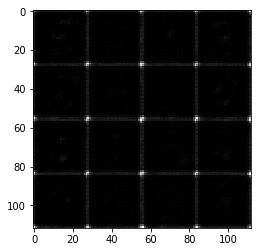

Epoch 1/2... Discriminator Loss: 1.1365... Generator Loss: 1.2817
Epoch 1/2... Discriminator Loss: 1.1295... Generator Loss: 1.7377
Epoch 1/2... Discriminator Loss: 1.3263... Generator Loss: 0.6881
Epoch 1/2... Discriminator Loss: 1.2354... Generator Loss: 2.4015
Epoch 1/2... Discriminator Loss: 1.1946... Generator Loss: 0.9109
Epoch 1/2... Discriminator Loss: 1.7095... Generator Loss: 3.1788
Epoch 1/2... Discriminator Loss: 1.0822... Generator Loss: 1.6337
Epoch 1/2... Discriminator Loss: 1.2563... Generator Loss: 0.7395
Epoch 1/2... Discriminator Loss: 1.1255... Generator Loss: 1.8454
Epoch 1/2... Discriminator Loss: 1.0868... Generator Loss: 1.0000
Gen: (?, 28, 28, 1)


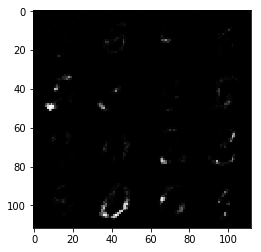

Epoch 1/2... Discriminator Loss: 1.4226... Generator Loss: 0.6015
Epoch 1/2... Discriminator Loss: 0.9662... Generator Loss: 1.3051
Epoch 1/2... Discriminator Loss: 1.2945... Generator Loss: 0.7144
Epoch 1/2... Discriminator Loss: 0.8584... Generator Loss: 2.3701
Epoch 1/2... Discriminator Loss: 1.3908... Generator Loss: 0.6251
Epoch 1/2... Discriminator Loss: 1.0510... Generator Loss: 2.2238
Epoch 1/2... Discriminator Loss: 0.8325... Generator Loss: 1.6745
Epoch 1/2... Discriminator Loss: 1.2436... Generator Loss: 2.3858
Epoch 1/2... Discriminator Loss: 1.1110... Generator Loss: 0.9381
Epoch 1/2... Discriminator Loss: 0.9837... Generator Loss: 1.7880
Gen: (?, 28, 28, 1)


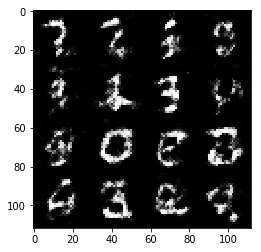

Epoch 1/2... Discriminator Loss: 0.9927... Generator Loss: 1.1853
Epoch 1/2... Discriminator Loss: 0.9727... Generator Loss: 1.2507
Epoch 1/2... Discriminator Loss: 1.1723... Generator Loss: 1.0029
Epoch 1/2... Discriminator Loss: 1.2482... Generator Loss: 0.8234
Epoch 1/2... Discriminator Loss: 1.0238... Generator Loss: 1.4443
Epoch 1/2... Discriminator Loss: 1.2269... Generator Loss: 1.9946
Epoch 1/2... Discriminator Loss: 1.1363... Generator Loss: 1.8400
Epoch 1/2... Discriminator Loss: 1.3253... Generator Loss: 2.9553
Epoch 1/2... Discriminator Loss: 1.1764... Generator Loss: 1.0441
Epoch 1/2... Discriminator Loss: 1.4144... Generator Loss: 0.6123
Gen: (?, 28, 28, 1)


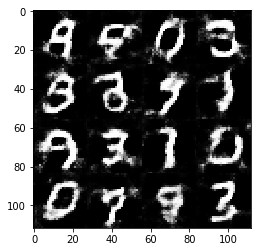

Epoch 1/2... Discriminator Loss: 0.9866... Generator Loss: 1.9020
Epoch 1/2... Discriminator Loss: 1.2164... Generator Loss: 0.8741
Epoch 1/2... Discriminator Loss: 1.3825... Generator Loss: 2.3603
Epoch 1/2... Discriminator Loss: 1.0990... Generator Loss: 1.0764
Epoch 1/2... Discriminator Loss: 1.0427... Generator Loss: 1.1215
Epoch 1/2... Discriminator Loss: 1.0365... Generator Loss: 1.1760
Epoch 1/2... Discriminator Loss: 1.1294... Generator Loss: 1.6453
Epoch 1/2... Discriminator Loss: 1.3331... Generator Loss: 0.7269
Epoch 1/2... Discriminator Loss: 1.4046... Generator Loss: 2.3942
Epoch 1/2... Discriminator Loss: 1.2488... Generator Loss: 2.3932
Gen: (?, 28, 28, 1)


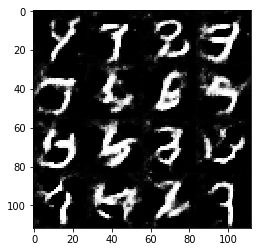

Epoch 1/2... Discriminator Loss: 1.2137... Generator Loss: 0.8262
Epoch 1/2... Discriminator Loss: 1.0588... Generator Loss: 1.0846
Epoch 1/2... Discriminator Loss: 1.1019... Generator Loss: 1.0833
Epoch 1/2... Discriminator Loss: 1.1892... Generator Loss: 0.9055
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 1.1342
Epoch 1/2... Discriminator Loss: 1.2691... Generator Loss: 0.7427
Epoch 1/2... Discriminator Loss: 1.1657... Generator Loss: 1.0219
Epoch 1/2... Discriminator Loss: 1.1366... Generator Loss: 1.7518
Epoch 1/2... Discriminator Loss: 1.1015... Generator Loss: 1.3559
Epoch 1/2... Discriminator Loss: 1.2610... Generator Loss: 2.1407
Gen: (?, 28, 28, 1)


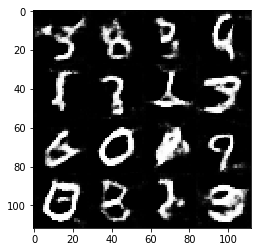

Epoch 1/2... Discriminator Loss: 1.0348... Generator Loss: 1.1511
Epoch 1/2... Discriminator Loss: 0.9909... Generator Loss: 1.4144
Epoch 1/2... Discriminator Loss: 1.0543... Generator Loss: 1.0988
Epoch 1/2... Discriminator Loss: 1.1546... Generator Loss: 0.9075
Epoch 1/2... Discriminator Loss: 1.0952... Generator Loss: 1.2936
Epoch 1/2... Discriminator Loss: 1.1479... Generator Loss: 0.9317
Epoch 1/2... Discriminator Loss: 0.9937... Generator Loss: 1.5553
Epoch 1/2... Discriminator Loss: 1.0181... Generator Loss: 1.1911
Epoch 1/2... Discriminator Loss: 1.0122... Generator Loss: 1.1901
Epoch 1/2... Discriminator Loss: 1.0735... Generator Loss: 1.3995
Gen: (?, 28, 28, 1)


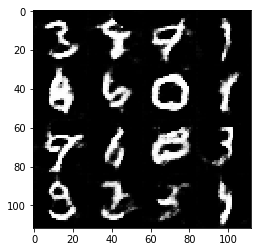

Epoch 1/2... Discriminator Loss: 1.0255... Generator Loss: 1.3454
Epoch 1/2... Discriminator Loss: 1.1718... Generator Loss: 2.0142
Epoch 1/2... Discriminator Loss: 1.0431... Generator Loss: 1.1421
Epoch 1/2... Discriminator Loss: 1.0226... Generator Loss: 1.1773
Epoch 1/2... Discriminator Loss: 1.2581... Generator Loss: 2.5162
Epoch 1/2... Discriminator Loss: 1.0406... Generator Loss: 1.4282
Epoch 1/2... Discriminator Loss: 1.0187... Generator Loss: 1.6018
Epoch 1/2... Discriminator Loss: 0.9586... Generator Loss: 1.2622
Epoch 1/2... Discriminator Loss: 1.3472... Generator Loss: 0.7049
Epoch 1/2... Discriminator Loss: 1.0422... Generator Loss: 1.1781
Gen: (?, 28, 28, 1)


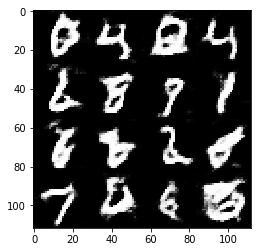

Epoch 1/2... Discriminator Loss: 1.1196... Generator Loss: 2.4769
Epoch 1/2... Discriminator Loss: 1.1829... Generator Loss: 2.3411
Epoch 1/2... Discriminator Loss: 1.0520... Generator Loss: 0.9984
Epoch 1/2... Discriminator Loss: 1.0360... Generator Loss: 1.1383
Epoch 1/2... Discriminator Loss: 0.8817... Generator Loss: 1.4250
Epoch 1/2... Discriminator Loss: 1.1087... Generator Loss: 0.9425
Epoch 1/2... Discriminator Loss: 1.0203... Generator Loss: 1.5933
Epoch 1/2... Discriminator Loss: 1.0431... Generator Loss: 1.1336
Epoch 1/2... Discriminator Loss: 1.0153... Generator Loss: 1.5328
Epoch 1/2... Discriminator Loss: 1.0085... Generator Loss: 1.1549
Gen: (?, 28, 28, 1)


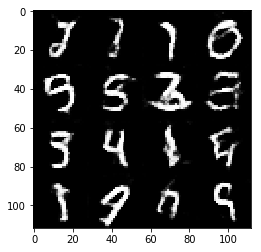

Epoch 1/2... Discriminator Loss: 0.9412... Generator Loss: 1.8088
Epoch 1/2... Discriminator Loss: 0.9021... Generator Loss: 1.3650
Epoch 1/2... Discriminator Loss: 2.5700... Generator Loss: 0.2551
Epoch 2/2... Discriminator Loss: 1.0097... Generator Loss: 1.2648
Epoch 2/2... Discriminator Loss: 0.9976... Generator Loss: 1.1125
Epoch 2/2... Discriminator Loss: 0.9747... Generator Loss: 1.3572
Epoch 2/2... Discriminator Loss: 1.0249... Generator Loss: 1.1048
Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 1.6459
Epoch 2/2... Discriminator Loss: 1.0484... Generator Loss: 1.0860
Epoch 2/2... Discriminator Loss: 1.1836... Generator Loss: 1.0157
Gen: (?, 28, 28, 1)


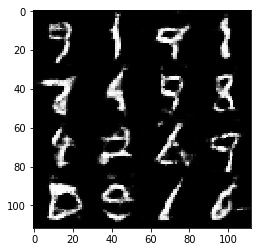

Epoch 2/2... Discriminator Loss: 0.9851... Generator Loss: 1.3736
Epoch 2/2... Discriminator Loss: 1.0230... Generator Loss: 1.2959
Epoch 2/2... Discriminator Loss: 1.1144... Generator Loss: 0.9054
Epoch 2/2... Discriminator Loss: 1.0505... Generator Loss: 1.0276
Epoch 2/2... Discriminator Loss: 1.5405... Generator Loss: 0.5732
Epoch 2/2... Discriminator Loss: 1.1058... Generator Loss: 0.9708
Epoch 2/2... Discriminator Loss: 1.0384... Generator Loss: 1.2126
Epoch 2/2... Discriminator Loss: 0.9559... Generator Loss: 1.2855
Epoch 2/2... Discriminator Loss: 1.3943... Generator Loss: 0.6432
Epoch 2/2... Discriminator Loss: 0.9785... Generator Loss: 1.3264
Gen: (?, 28, 28, 1)


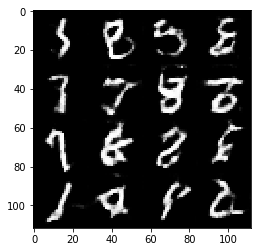

Epoch 2/2... Discriminator Loss: 1.2873... Generator Loss: 0.7448
Epoch 2/2... Discriminator Loss: 0.8950... Generator Loss: 1.3114
Epoch 2/2... Discriminator Loss: 0.9646... Generator Loss: 1.8967
Epoch 2/2... Discriminator Loss: 1.1261... Generator Loss: 2.0816
Epoch 2/2... Discriminator Loss: 1.0844... Generator Loss: 1.0189
Epoch 2/2... Discriminator Loss: 0.9384... Generator Loss: 2.3005
Epoch 2/2... Discriminator Loss: 0.9589... Generator Loss: 1.1938
Epoch 2/2... Discriminator Loss: 1.4393... Generator Loss: 0.7265
Epoch 2/2... Discriminator Loss: 1.1186... Generator Loss: 1.0297
Epoch 2/2... Discriminator Loss: 1.0632... Generator Loss: 1.9944
Gen: (?, 28, 28, 1)


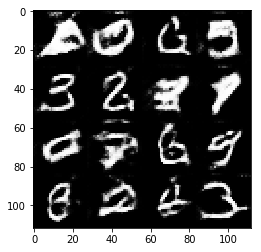

Epoch 2/2... Discriminator Loss: 0.9602... Generator Loss: 2.0806
Epoch 2/2... Discriminator Loss: 1.4185... Generator Loss: 0.6479
Epoch 2/2... Discriminator Loss: 1.1881... Generator Loss: 0.8131
Epoch 2/2... Discriminator Loss: 0.9794... Generator Loss: 1.4679
Epoch 2/2... Discriminator Loss: 1.0288... Generator Loss: 1.0635
Epoch 2/2... Discriminator Loss: 1.0753... Generator Loss: 0.9708
Epoch 2/2... Discriminator Loss: 0.9455... Generator Loss: 1.2597
Epoch 2/2... Discriminator Loss: 0.9638... Generator Loss: 2.0784
Epoch 2/2... Discriminator Loss: 1.3987... Generator Loss: 3.2048
Epoch 2/2... Discriminator Loss: 1.1902... Generator Loss: 0.9014
Gen: (?, 28, 28, 1)


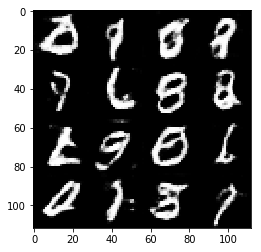

Epoch 2/2... Discriminator Loss: 0.9317... Generator Loss: 1.5825
Epoch 2/2... Discriminator Loss: 0.9060... Generator Loss: 1.3736
Epoch 2/2... Discriminator Loss: 1.0125... Generator Loss: 1.5690
Epoch 2/2... Discriminator Loss: 0.9855... Generator Loss: 2.0310
Epoch 2/2... Discriminator Loss: 0.9409... Generator Loss: 1.3478
Epoch 2/2... Discriminator Loss: 1.0777... Generator Loss: 0.9990
Epoch 2/2... Discriminator Loss: 1.5356... Generator Loss: 3.2567
Epoch 2/2... Discriminator Loss: 1.1433... Generator Loss: 0.9592
Epoch 2/2... Discriminator Loss: 1.1628... Generator Loss: 0.9249
Epoch 2/2... Discriminator Loss: 0.9121... Generator Loss: 1.3736
Gen: (?, 28, 28, 1)


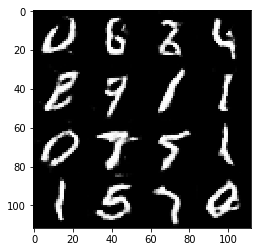

Epoch 2/2... Discriminator Loss: 1.0875... Generator Loss: 1.0251
Epoch 2/2... Discriminator Loss: 0.9608... Generator Loss: 1.5222
Epoch 2/2... Discriminator Loss: 1.1282... Generator Loss: 0.9569
Epoch 2/2... Discriminator Loss: 0.9837... Generator Loss: 1.1832
Epoch 2/2... Discriminator Loss: 0.9640... Generator Loss: 1.1845
Epoch 2/2... Discriminator Loss: 0.8582... Generator Loss: 1.6891
Epoch 2/2... Discriminator Loss: 1.2515... Generator Loss: 0.8010
Epoch 2/2... Discriminator Loss: 1.1868... Generator Loss: 2.4608
Epoch 2/2... Discriminator Loss: 1.0224... Generator Loss: 1.5388
Epoch 2/2... Discriminator Loss: 0.9435... Generator Loss: 1.7504
Gen: (?, 28, 28, 1)


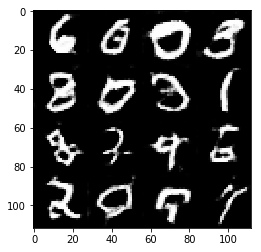

Epoch 2/2... Discriminator Loss: 1.2963... Generator Loss: 0.7055
Epoch 2/2... Discriminator Loss: 1.3559... Generator Loss: 0.6918
Epoch 2/2... Discriminator Loss: 1.2187... Generator Loss: 0.8761
Epoch 2/2... Discriminator Loss: 1.1309... Generator Loss: 1.0329
Epoch 2/2... Discriminator Loss: 0.8927... Generator Loss: 1.4500
Epoch 2/2... Discriminator Loss: 1.2380... Generator Loss: 0.8738
Epoch 2/2... Discriminator Loss: 1.0166... Generator Loss: 1.1772
Epoch 2/2... Discriminator Loss: 1.1610... Generator Loss: 0.8934
Epoch 2/2... Discriminator Loss: 0.9974... Generator Loss: 1.4450
Epoch 2/2... Discriminator Loss: 0.9488... Generator Loss: 1.6220
Gen: (?, 28, 28, 1)


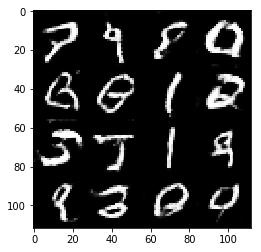

Epoch 2/2... Discriminator Loss: 1.1539... Generator Loss: 0.9338
Epoch 2/2... Discriminator Loss: 1.1041... Generator Loss: 0.9759
Epoch 2/2... Discriminator Loss: 0.9330... Generator Loss: 1.4429
Epoch 2/2... Discriminator Loss: 0.9867... Generator Loss: 1.4031
Epoch 2/2... Discriminator Loss: 1.1654... Generator Loss: 0.9593
Epoch 2/2... Discriminator Loss: 0.8541... Generator Loss: 1.8603
Epoch 2/2... Discriminator Loss: 1.0152... Generator Loss: 1.3893
Epoch 2/2... Discriminator Loss: 0.9827... Generator Loss: 2.0792
Epoch 2/2... Discriminator Loss: 1.2820... Generator Loss: 0.8024
Epoch 2/2... Discriminator Loss: 1.1727... Generator Loss: 2.0612
Gen: (?, 28, 28, 1)


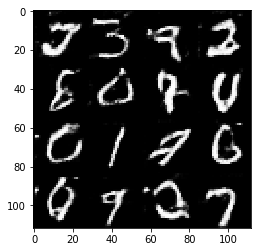

Epoch 2/2... Discriminator Loss: 1.1191... Generator Loss: 0.9032
Epoch 2/2... Discriminator Loss: 1.2914... Generator Loss: 0.8317
Epoch 2/2... Discriminator Loss: 1.0245... Generator Loss: 1.1496
Epoch 2/2... Discriminator Loss: 0.9449... Generator Loss: 1.4732
Epoch 2/2... Discriminator Loss: 1.1327... Generator Loss: 1.9103
Epoch 2/2... Discriminator Loss: 1.1996... Generator Loss: 2.5444
Epoch 2/2... Discriminator Loss: 1.0385... Generator Loss: 1.8116
Epoch 2/2... Discriminator Loss: 0.9824... Generator Loss: 2.0058
Epoch 2/2... Discriminator Loss: 1.0302... Generator Loss: 1.6073
Epoch 2/2... Discriminator Loss: 1.0044... Generator Loss: 1.6682
Gen: (?, 28, 28, 1)


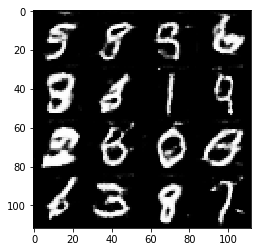

Epoch 2/2... Discriminator Loss: 1.0411... Generator Loss: 2.0617
Epoch 2/2... Discriminator Loss: 1.3016... Generator Loss: 0.7499
Epoch 2/2... Discriminator Loss: 0.9582... Generator Loss: 1.3274
Epoch 2/2... Discriminator Loss: 1.0283... Generator Loss: 1.2516
Epoch 2/2... Discriminator Loss: 0.9400... Generator Loss: 1.3885
Epoch 2/2... Discriminator Loss: 1.2044... Generator Loss: 0.9328
Epoch 2/2... Discriminator Loss: 0.8205... Generator Loss: 1.5760


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 =0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Gen: (?, 28, 28, 3)
Disc: (?, 1)
Disc: (?, 1)
Epoch 1/1... Discriminator Loss: 0.6008... Generator Loss: 7.3627
Epoch 1/1... Discriminator Loss: 0.7945... Generator Loss: 4.2542
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 6.2075
Epoch 1/1... Discriminator Loss: 0.8863... Generator Loss: 10.8780
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 1.9988
Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 5.3918
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 1.6190
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 5.8375
Epoch 1/1... Discriminator Loss: 1.8107... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 0.7952... Generator Loss: 2.6697
Gen: (?, 28, 28, 3)


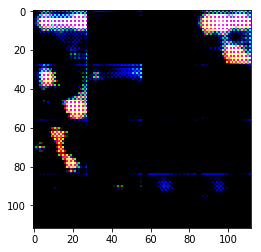

Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 3.6122
Epoch 1/1... Discriminator Loss: 0.6404... Generator Loss: 5.0184
Epoch 1/1... Discriminator Loss: 2.5708... Generator Loss: 0.3739
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 1.6056
Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 2.1060
Epoch 1/1... Discriminator Loss: 0.8155... Generator Loss: 2.4173
Epoch 1/1... Discriminator Loss: 0.7044... Generator Loss: 2.2403
Epoch 1/1... Discriminator Loss: 0.5903... Generator Loss: 5.3678
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 1.7713
Epoch 1/1... Discriminator Loss: 0.7933... Generator Loss: 2.2039
Gen: (?, 28, 28, 3)


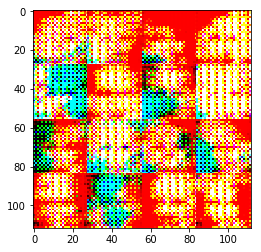

Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 4.3976
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 1.6795
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 2.0475
Epoch 1/1... Discriminator Loss: 2.4174... Generator Loss: 5.0829
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 1.1135
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 2.8171
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 4.0869
Epoch 1/1... Discriminator Loss: 0.7173... Generator Loss: 2.1661
Epoch 1/1... Discriminator Loss: 0.6069... Generator Loss: 5.4414
Epoch 1/1... Discriminator Loss: 0.5957... Generator Loss: 4.6463
Gen: (?, 28, 28, 3)


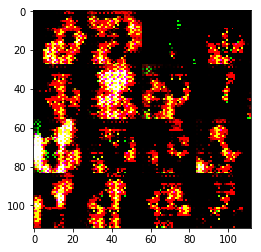

Epoch 1/1... Discriminator Loss: 0.5554... Generator Loss: 3.6858
Epoch 1/1... Discriminator Loss: 0.5513... Generator Loss: 3.7527
Epoch 1/1... Discriminator Loss: 0.5185... Generator Loss: 7.3478
Epoch 1/1... Discriminator Loss: 0.5309... Generator Loss: 4.3388
Epoch 1/1... Discriminator Loss: 0.5340... Generator Loss: 5.1807
Epoch 1/1... Discriminator Loss: 0.5300... Generator Loss: 4.2592
Epoch 1/1... Discriminator Loss: 0.5400... Generator Loss: 4.7676
Epoch 1/1... Discriminator Loss: 0.5160... Generator Loss: 9.0582
Epoch 1/1... Discriminator Loss: 0.5354... Generator Loss: 4.6028
Epoch 1/1... Discriminator Loss: 0.5207... Generator Loss: 4.5324
Gen: (?, 28, 28, 3)


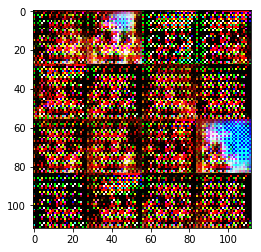

Epoch 1/1... Discriminator Loss: 0.5361... Generator Loss: 3.6833
Epoch 1/1... Discriminator Loss: 0.5066... Generator Loss: 8.0076
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 1.4110
Epoch 1/1... Discriminator Loss: 0.5753... Generator Loss: 4.5041
Epoch 1/1... Discriminator Loss: 0.6303... Generator Loss: 5.7071
Epoch 1/1... Discriminator Loss: 0.5553... Generator Loss: 4.7824
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 1.5196
Epoch 1/1... Discriminator Loss: 0.8676... Generator Loss: 1.5575
Epoch 1/1... Discriminator Loss: 0.7682... Generator Loss: 3.1317
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 1.9347
Gen: (?, 28, 28, 3)


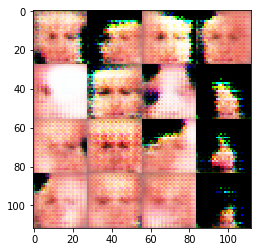

Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 1.8510
Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 1.5747
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 2.0450
Epoch 1/1... Discriminator Loss: 0.5701... Generator Loss: 4.0841
Epoch 1/1... Discriminator Loss: 0.5927... Generator Loss: 3.1214
Epoch 1/1... Discriminator Loss: 0.8187... Generator Loss: 2.7210
Epoch 1/1... Discriminator Loss: 0.7468... Generator Loss: 1.8927
Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 1.2634
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 3.2389
Epoch 1/1... Discriminator Loss: 1.9226... Generator Loss: 0.6496
Gen: (?, 28, 28, 3)


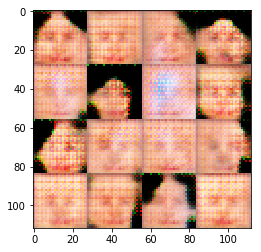

Epoch 1/1... Discriminator Loss: 0.7085... Generator Loss: 2.5095
Epoch 1/1... Discriminator Loss: 1.9233... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 1.8319
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 2.1250
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 1.6168
Epoch 1/1... Discriminator Loss: 1.5438... Generator Loss: 1.7321
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 1.2276
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 1.2157
Epoch 1/1... Discriminator Loss: 1.6166... Generator Loss: 0.7840
Gen: (?, 28, 28, 3)


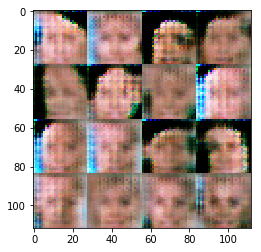

Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 2.0328
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.7887
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 1.6746
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.5593... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 2.1162
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 1.2024
Epoch 1/1... Discriminator Loss: 2.3432... Generator Loss: 0.2635
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 1.2444
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 2.2615
Gen: (?, 28, 28, 3)


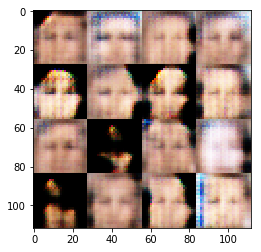

Epoch 1/1... Discriminator Loss: 2.1838... Generator Loss: 3.5390
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 1.2622
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 1.1969
Epoch 1/1... Discriminator Loss: 1.5704... Generator Loss: 0.7193
Gen: (?, 28, 28, 3)


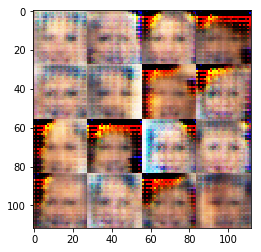

Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 1.1481
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 1.7253
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 1.4726
Epoch 1/1... Discriminator Loss: 1.6477... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 1.0728
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 1.1691
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 1.0856
Gen: (?, 28, 28, 3)


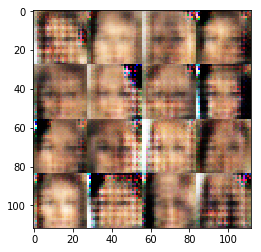

Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 1.0488
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 1.2974
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 1.0521
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 1.6831
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 1.2946
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 1.1127
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.8736
Gen: (?, 28, 28, 3)


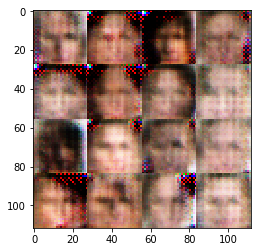

Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 1.5603
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 1.4575
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.9986
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 1.1085
Epoch 1/1... Discriminator Loss: 1.6503... Generator Loss: 0.4232
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 1.3869
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 1.4689
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 1.1959
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 1.1874
Gen: (?, 28, 28, 3)


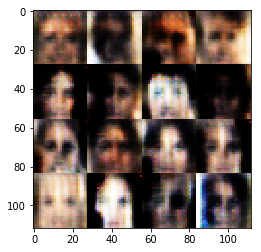

Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 1.0717
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 1.3321
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 1.1493
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 1.6950
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 0.9692
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 1.5039
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 0.9576
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 2.3026
Gen: (?, 28, 28, 3)


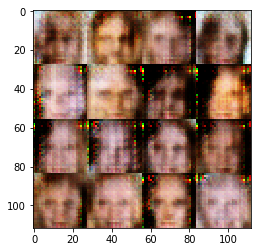

Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 1.1672
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 2.3251... Generator Loss: 0.2944
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 1.2387
Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 1.3047
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 1.2013
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 1.8430
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 1.1376
Gen: (?, 28, 28, 3)


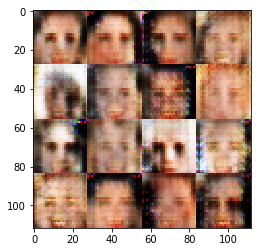

Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 1.2285
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.9522
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 1.0448
Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 1.0797
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 1.0025
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 1.1612
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 1.0149
Gen: (?, 28, 28, 3)


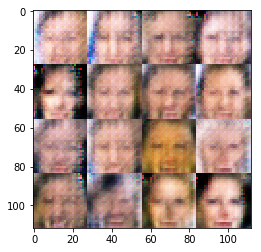

Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 1.1806
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 0.9827
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.9101
Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 1.3140
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 1.4894
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 1.0223
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.6748
Gen: (?, 28, 28, 3)


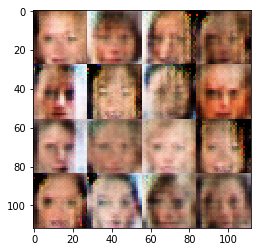

Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 1.3152
Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 2.1185
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 1.0409
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 1.1605
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 1.3897
Gen: (?, 28, 28, 3)


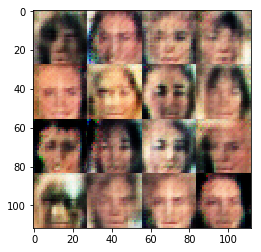

Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 1.2515
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 1.1257
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 1.3002
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 1.1511
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 1.3415
Epoch 1/1... Discriminator Loss: 1.6487... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.6430... Generator Loss: 0.7050
Gen: (?, 28, 28, 3)


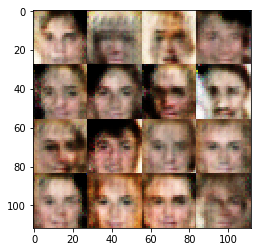

Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 1.1289
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 1.0993
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 1.2301
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.9966
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 1.2408
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 1.2039
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.9613
Gen: (?, 28, 28, 3)


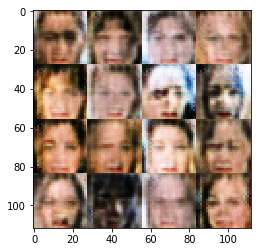

Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 1.1265
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 1.1133
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 1.2281
Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.4899
Epoch 1/1... Discriminator Loss: 1.0283... Generator Loss: 1.6195
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 1.3131
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 1.1214
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.9619
Gen: (?, 28, 28, 3)


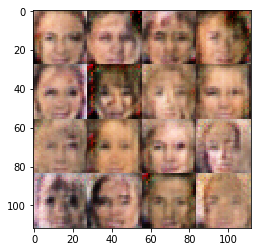

Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 1.0968
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 1.0831
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 1.0891
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.9467
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 1.1249
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 1.1269
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 1.1486
Gen: (?, 28, 28, 3)


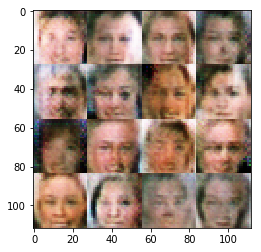

Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 1.2256
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 1.1734
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 1.0325
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 1.0525
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 1.0193
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 1.0787
Gen: (?, 28, 28, 3)


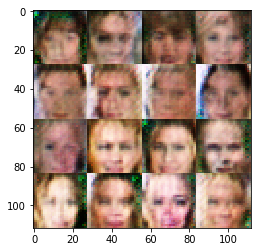

Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.6194... Generator Loss: 1.9862
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 1.0771
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.9527
Gen: (?, 28, 28, 3)


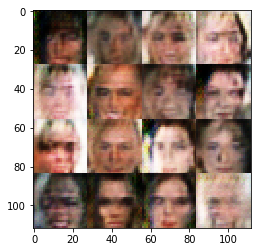

Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.9471
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.9718
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.9998
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.9758
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 1.1461
Gen: (?, 28, 28, 3)


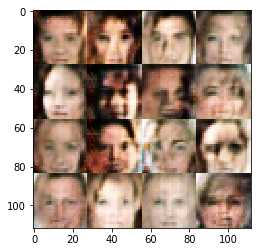

Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 1.1869
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.9921
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 0.9616
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 1.0905
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 1.0833
Gen: (?, 28, 28, 3)


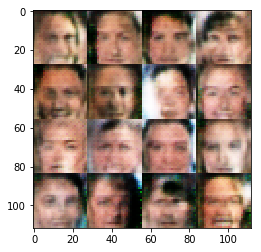

Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 1.1581
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 1.0054
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 1.0095
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 1.0368
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 0.9649
Gen: (?, 28, 28, 3)


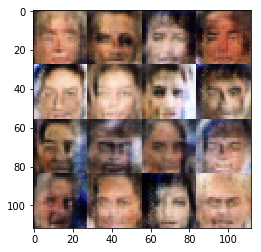

Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 1.2583
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 1.0101
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 1.0302
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 1.0478
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 1.0201
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 1.0416
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.9444
Gen: (?, 28, 28, 3)


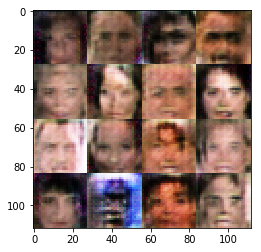

Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.9102
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 1.0870
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 1.3156
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 1.1642
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 1.1937
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 1.0300
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 1.0094
Gen: (?, 28, 28, 3)


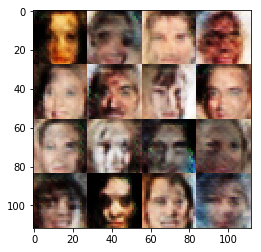

Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 1.1568
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 1.0877
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 1.1375
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 1.2353
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.8629
Gen: (?, 28, 28, 3)


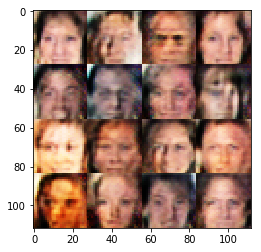

Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.9853
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 1.0386
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.9925
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 1.0677
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 1.0007
Gen: (?, 28, 28, 3)


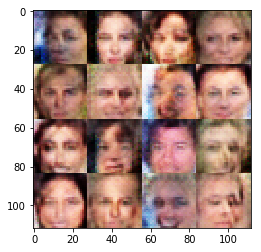

Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 1.0077
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.9294
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.9460
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 1.0350
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.8909
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.8973
Gen: (?, 28, 28, 3)


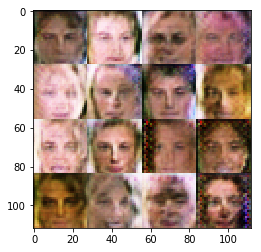

Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 1.1543
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 1.1631
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 1.0474
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.9617
Gen: (?, 28, 28, 3)


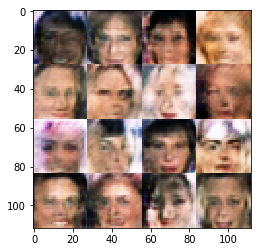

Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.9514
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 1.1705
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 1.0264
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.9845
Epoch 1/1... Discriminator Loss: 1.5398... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.9533
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 1.0233
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.8211
Gen: (?, 28, 28, 3)


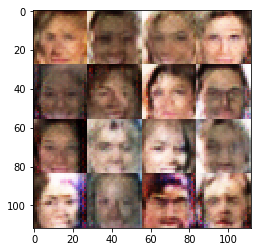

Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 1.1220
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.9660
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 1.1220
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 1.0266
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.8153
Gen: (?, 28, 28, 3)


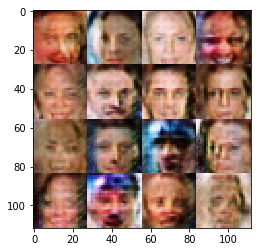

Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.9979
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 1.1067
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 1.1130
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 1.0491
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 1.0724
Gen: (?, 28, 28, 3)


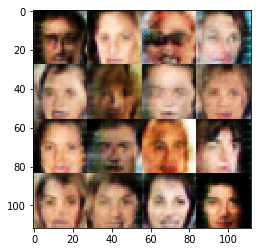

Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 1.1386
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 1.1587
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.9125
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.8307
Gen: (?, 28, 28, 3)


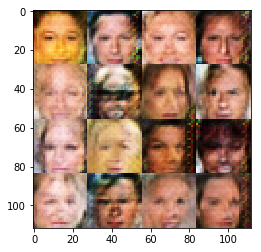

Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.9813
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 1.0197
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 1.1258
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.9523
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.9806
Gen: (?, 28, 28, 3)


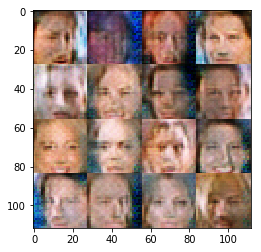

Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 1.0142
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 1.1538
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.9394
Gen: (?, 28, 28, 3)


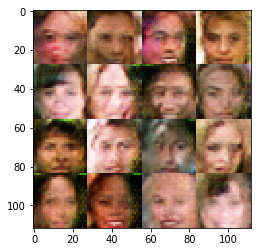

Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 1.1612
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.9965
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.9035
Gen: (?, 28, 28, 3)


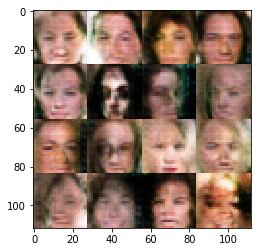

Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.9653
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.9576
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 1.0580
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 1.0160
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 1.0551
Gen: (?, 28, 28, 3)


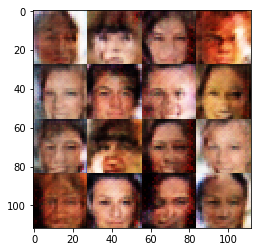

Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 1.0531
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 1.0547
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 1.0623
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 1.1244
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.8966
Gen: (?, 28, 28, 3)


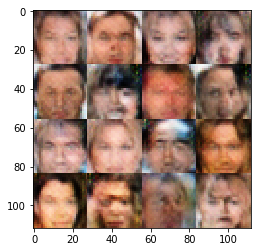

Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 1.0034
Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 1.0341
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.9642
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.9821
Gen: (?, 28, 28, 3)


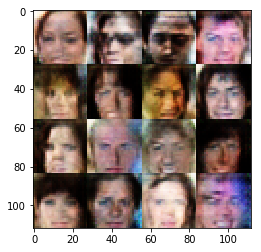

Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.9355
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 1.0125
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 1.0537
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.9544
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.9020
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 1.7848
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 0.9907
Gen: (?, 28, 28, 3)


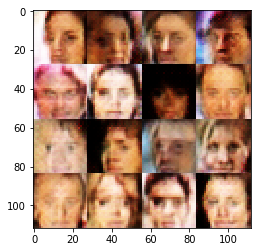

Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 1.1208
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.9977
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 1.0281
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.8713
Gen: (?, 28, 28, 3)


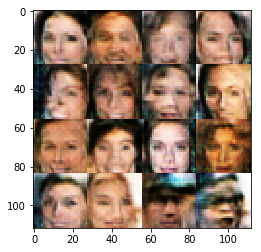

Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 1.0868
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.9242
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.6388
Gen: (?, 28, 28, 3)


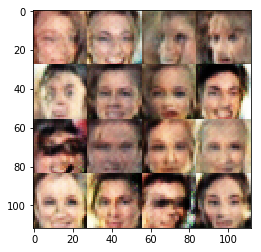

Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 1.0591
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.9249
Gen: (?, 28, 28, 3)


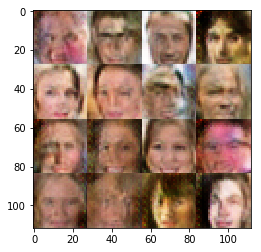

Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.8466
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.8508
Gen: (?, 28, 28, 3)


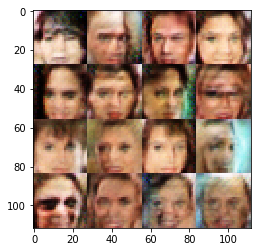

Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 1.1116
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 1.0385
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 1.0342
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 1.0748
Gen: (?, 28, 28, 3)


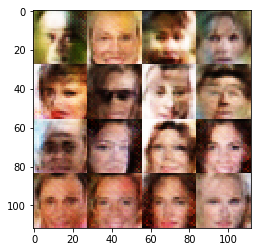

Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 1.0369
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.9725
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.9275
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 1.0216
Gen: (?, 28, 28, 3)


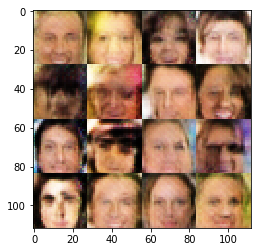

Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 1.0014
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.9832
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 1.1749
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.9947
Gen: (?, 28, 28, 3)


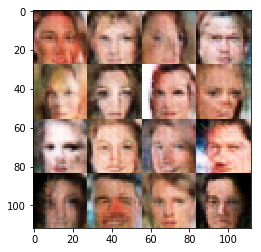

Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.9206
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.9943
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.9638
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.9301
Gen: (?, 28, 28, 3)


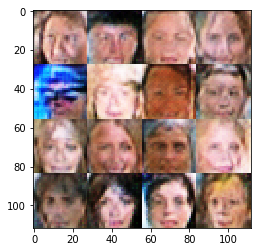

Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.9910
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 1.0426
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.9258
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.9494
Gen: (?, 28, 28, 3)


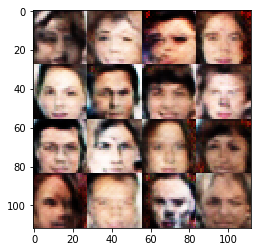

Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 1.0745
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.9798
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 1.0209
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 1.0440
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.8237
Gen: (?, 28, 28, 3)


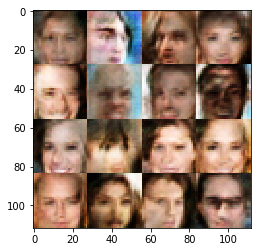

Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.9175
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 1.0902
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6467
Gen: (?, 28, 28, 3)


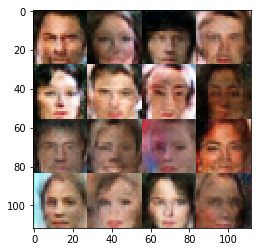

Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 1.0613
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.9704
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.9631
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 1.0604
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.9899
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.7437
Gen: (?, 28, 28, 3)


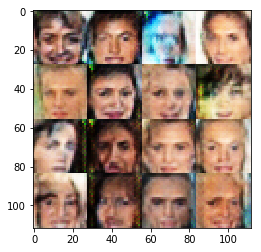

Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.9977
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 1.2650
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.9780
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.9678
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.9821
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.8601
Gen: (?, 28, 28, 3)


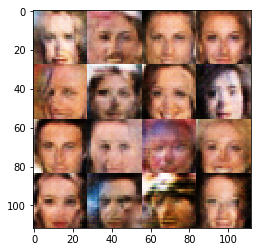

Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 1.0114
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.9880
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.9404
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 1.0006
Gen: (?, 28, 28, 3)


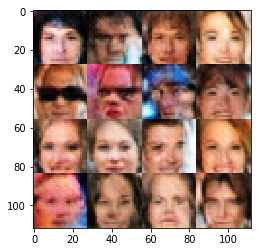

Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 1.0839
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.9344
Gen: (?, 28, 28, 3)


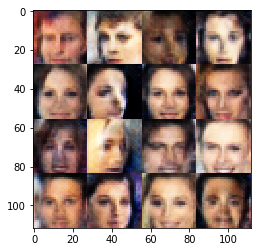

Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.9558
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7875
Gen: (?, 28, 28, 3)


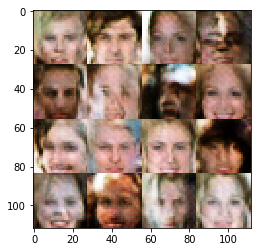

Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.9853
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 1.0081
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.9206
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.9775
Gen: (?, 28, 28, 3)


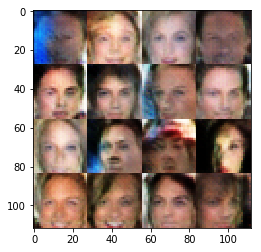

Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.9020
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 1.0653
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.9328
Gen: (?, 28, 28, 3)


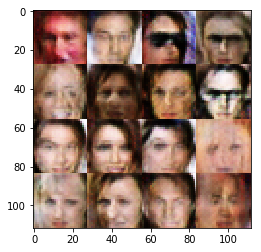

Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 1.0438
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.8234
Gen: (?, 28, 28, 3)


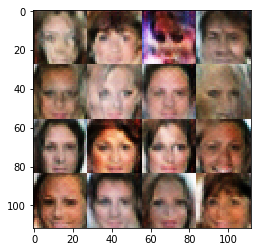

Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.8573
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.9694
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.9939
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.8682
Gen: (?, 28, 28, 3)


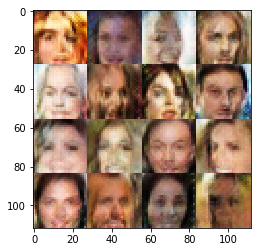

Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 1.0513
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 1.0150


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 =0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.